В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [26]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time


from process_bank_churn import preprocess_data, preprocess_new_data

In [2]:
train_df = pd.read_csv('train.csv')

In [4]:
X_train, y_train, X_val, y_val, input_cols, scaler, encoder, numeric_cols, categorical_cols = preprocess_data(
    train_df, scaler_numeric=True)


In [6]:
print('train_df.shape:', train_df.shape)
print('X_train.shape:', X_train.shape)
print('X_val.shape: ', X_val.shape)

train_df.shape: (15000, 14)
X_train.shape: (12000, 15)
X_val.shape:  (3000, 15)


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [9]:
knn = KNeighborsClassifier()  
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [10]:
y_train_proba = knn.predict_proba(X_train)[:, 1]
y_val_proba = knn.predict_proba(X_val)[:, 1]

In [11]:
auroc_train = roc_auc_score(y_train, y_train_proba)
auroc_val = roc_auc_score(y_val, y_val_proba)

print(f"AUROC на тренувальному наборі: {auroc_train:.4f}")
print(f"AUROC на валідаційному наборі: {auroc_val:.4f}")

AUROC на тренувальному наборі: 0.9495
AUROC на валідаційному наборі: 0.8523


### Інтерпретація  
Модель хороша, але має високу дисперсію (high variance), тобто вона запам’ятала тренувальні приклади краще, ніж узагальнила.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [13]:
param_grid = {'n_neighbors': list(range(1, 31))}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Найкраще n_neighbors: {best_k}")

Найкраще n_neighbors: 22


In [14]:
knn_best = grid_search.best_estimator_

In [15]:
y_train_pred_proba = knn_best.predict_proba(X_train)[:, 1]
y_val_pred_proba = knn_best.predict_proba(X_val)[:, 1]

auroc_train_best = roc_auc_score(y_train, y_train_pred_proba)
auroc_val_best = roc_auc_score(y_val, y_val_pred_proba)

print(f"AUROC на тренувальному наборі (best): {auroc_train_best:.4f}")
print(f"AUROC на валідаційному наборі (best): {auroc_val_best:.4f}")

AUROC на тренувальному наборі (best): 0.9094
AUROC на валідаційному наборі (best): 0.8743


### Інтерпретація  

- Модель покращилась після підбору параметра `n_neighbors`.
- Має менше overfitting і кращу якість на валідації.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [22]:
dt = DecisionTreeClassifier(random_state=42)

In [23]:
param_grid = {
    'max_depth': list(range(1, 21, 2)),         
    'max_leaf_nodes': list(range(2, 11, 1))     
}

grid_search_dt = GridSearchCV(
    dt,
    param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

start_time = time.time()
grid_search_dt.fit(X_train, y_train)
end_time = time.time()

print(f"Час пошуку оптимальних гіперпараметрів: {end_time - start_time:.2f} с")
print("Найкращі параметри дерева рішень:", grid_search_dt.best_params_)

Час пошуку оптимальних гіперпараметрів: 1.74 с
Найкращі параметри дерева рішень: {'max_depth': 5, 'max_leaf_nodes': 10}


In [24]:
dt_best = grid_search_dt.best_estimator_

In [25]:
y_train_proba_dt = dt_best.predict_proba(X_train)[:, 1]
y_val_proba_dt = dt_best.predict_proba(X_val)[:, 1]

auroc_train_dt = roc_auc_score(y_train, y_train_proba_dt)
auroc_val_dt = roc_auc_score(y_val, y_val_proba_dt)

print(f"AUROC на тренувальному наборі (dt_best): {auroc_train_dt:.4f}")
print(f"AUROC на валідаційному наборі (dt_best): {auroc_val_dt:.4f}")

AUROC на тренувальному наборі (dt_best): 0.8995
AUROC на валідаційному наборі (dt_best): 0.9080


4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [27]:
random_state = 42
np.random.seed(random_state)

params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [28]:
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=params_dt,
    n_iter=40,
    cv=3,
    scoring='roc_auc',
    random_state=random_state,
    n_jobs=-1
)

In [29]:
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
print(f"Час пошуку (RandomizedSearchCV): {end_time - start_time:.2f} с")

print("Найкращі параметри (random search):", random_search.best_params_)

Час пошуку (RandomizedSearchCV): 2.54 с
Найкращі параметри (random search): {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}


In [30]:
dt_random_search_best = random_search.best_estimator_

In [31]:
y_train_proba_rand = dt_random_search_best.predict_proba(X_train)[:, 1]
y_val_proba_rand = dt_random_search_best.predict_proba(X_val)[:, 1]

auroc_train_rand = roc_auc_score(y_train, y_train_proba_rand)
auroc_val_rand = roc_auc_score(y_val, y_val_proba_rand)

print(f"AUROC на тренувальному наборі (random search): {auroc_train_rand:.4f}")
print(f"AUROC на валідаційному наборі (random search): {auroc_val_rand:.4f}")

AUROC на тренувальному наборі (random search): 0.9159
AUROC на валідаційному наборі (random search): 0.9218


- RandomizedSearchCV знайшов більш регуляризовану і глибшу модель, яка використовує інший критерій (entropy замість gini)
- Має глибше дерево (`max_depth=16`) >> більше потенціалу для складних залежностей
- Але не так агресивно розщеплює завдяки `min_samples_split=20` та `min_samples_leaf=2` >> менший ризик overfitting
- RandomizedSearch виявився ефективнішим, ніж GridSearch у задачі оптимізації дерева рішень

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [36]:
test_df = pd.read_csv("test.csv")

X_test = preprocess_new_data(
    new_df=test_df,
    input_cols=input_cols,
    scaler=scaler,
    encoder=encoder,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    scale_numeric=True
)


test_probs = dt_random_search_best.predict_proba(X_test)[:, 1]

submission_df = pd.read_csv('./sample_submission.csv')
submission_df['Exited'] = test_probs
display(submission_df.head())
submission_df.to_csv('submission_random.csv', index=False)

,id,Exited
0,15000,0.262327
1,15001,0.010557
2,15002,0.196544
3,15003,0.551105
4,15004,0.083086


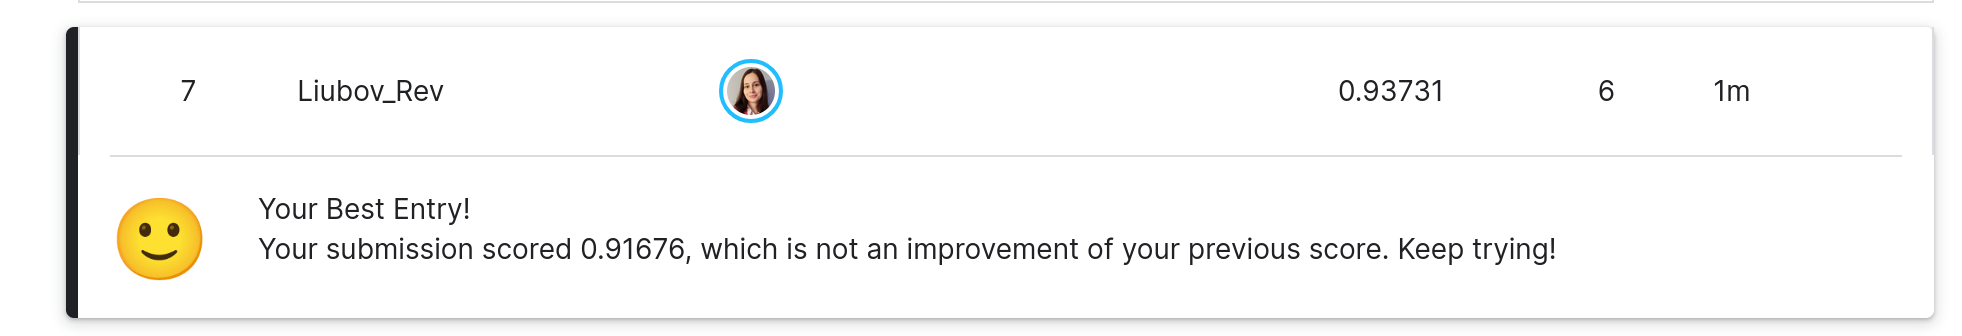